,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


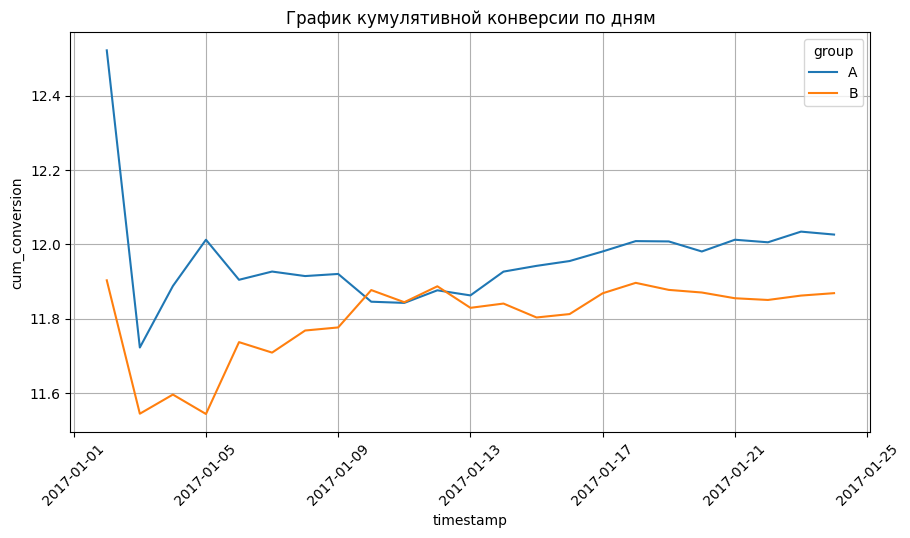

In [135]:
import pandas as pd
ab_data = pd.read_csv('data/ab_data.csv')
import matplotlib.pyplot as plt
import seaborn as sns

ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})

daily_data['conversion'] = daily_data['converted']/daily_data['users_count']*100
round(daily_data[daily_data['timestamp'] == '2017-01-05'],2)
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)
# выделяем данные группы А
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);


0.71

0.76

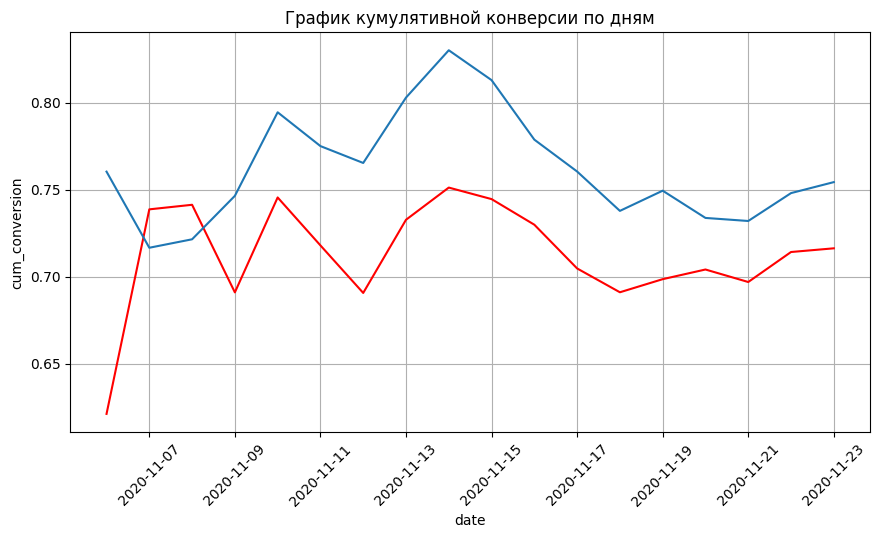

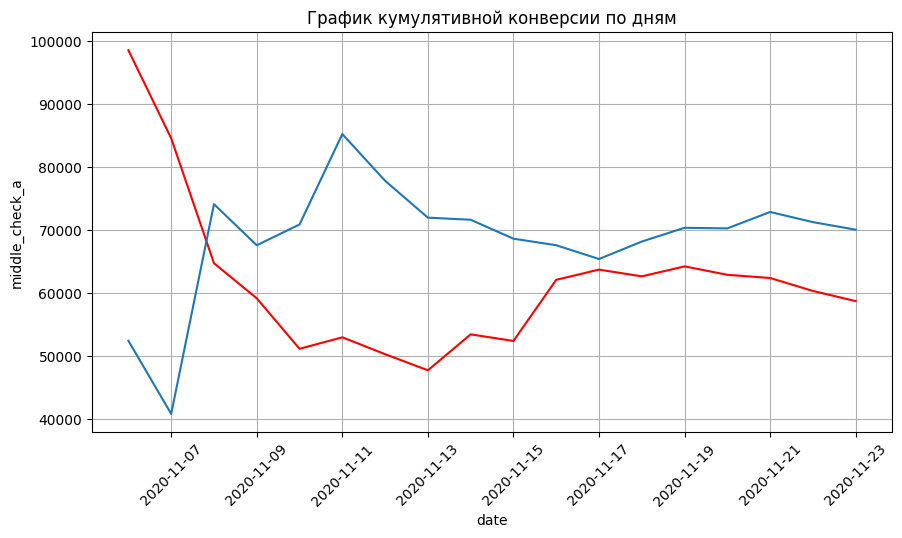

In [136]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

daily_a = sample_a.groupby(['date']).agg({'cid':'count','revenue':'sum', 'transactions': 'sum'}).reset_index()

daily_a['cum_users_count'] = daily_a['cid'].cumsum()
daily_a['cum_revenue'] = daily_a['revenue'].cumsum()
daily_a['cum_transactions'] = daily_a['transactions'].cumsum()
daily_a['cum_conversion'] = daily_a['cum_transactions']/daily_a['cum_users_count']*100
daily_a['middle_check_a'] = daily_a['cum_revenue']/daily_a['cum_transactions']
display(round(daily_a['cum_conversion'].mean(),2))


daily_b = sample_b.groupby(['date']).agg({'cid':'count','revenue':'sum', 'transactions': 'sum'}).reset_index()
daily_b['cum_users_count'] = daily_b['cid'].cumsum()
daily_b['cum_revenue'] = daily_b['revenue'].cumsum()
daily_b['cum_transactions'] = daily_b['transactions'].cumsum()
daily_b['cum_conversion'] = daily_b['cum_transactions']/daily_b['cum_users_count']*100
daily_b['middle_check_b'] = daily_b['cum_revenue']/daily_b['cum_transactions']
display(round(daily_b['cum_conversion'].mean(),2))

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_a, ax=ax, color ='red')
sns.lineplot(x='date', y='cum_conversion', data=daily_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='middle_check_a', data=daily_a, ax=ax, color ='red')
sns.lineplot(x='date', y='middle_check_b', data=daily_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)



In [137]:
from statsmodels.stats.proportion import proportions_ztest
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


,sum,count
group,,
A,17467,145241
B,17238,145241


p-value:  0.1
Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B


Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


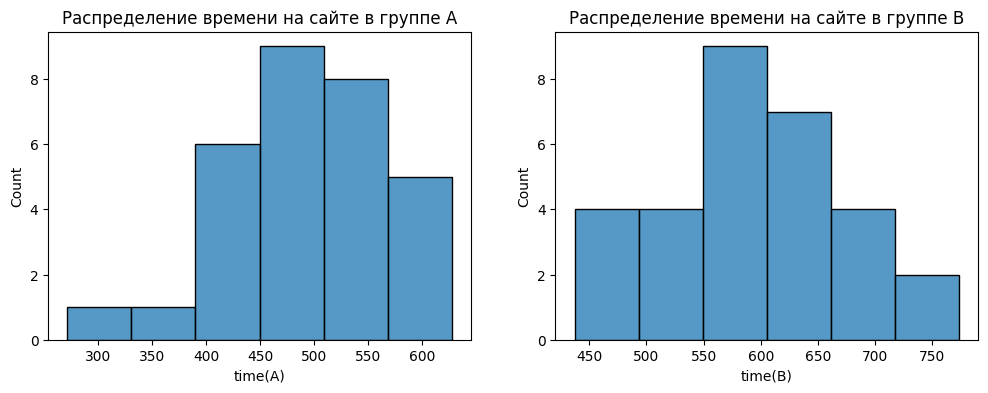

In [138]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())
# Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

#Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений
# с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

Выдвигаем нулевую гипотезу:

, то есть среднее время в группах А и B одинаково.
При левосторонней альтернативной гипотезе:

, то есть среднее время в группе А меньше, чем в группе B.
✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [139]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите .

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


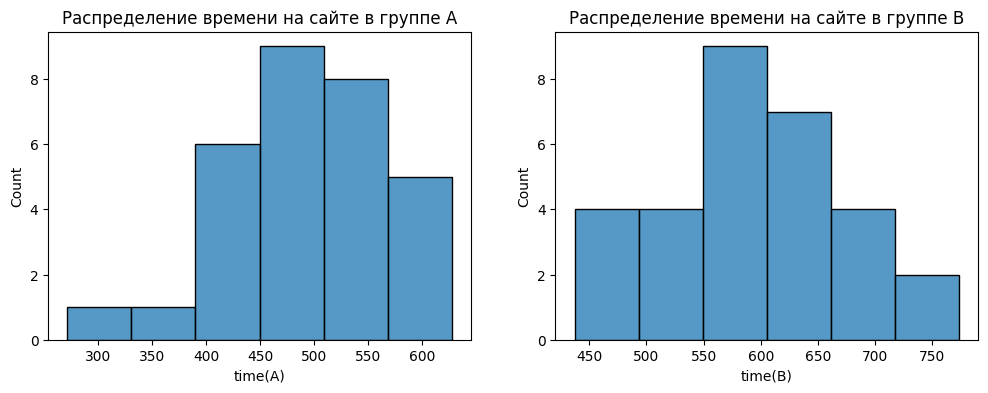

In [140]:

converted_piv_b= sample_b.groupby('group')['transactions'].agg(['sum', 'count'])
converted_piv_a= sample_a.groupby('group')['transactions'].agg(['sum', 'count'])
converted_piv_ab = pd.concat([converted_piv_a, converted_piv_b])

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv_ab['sum'], #число "успехов"
    nobs=converted_piv_ab['count'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');



Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите .

Каковы результаты тестирования?

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


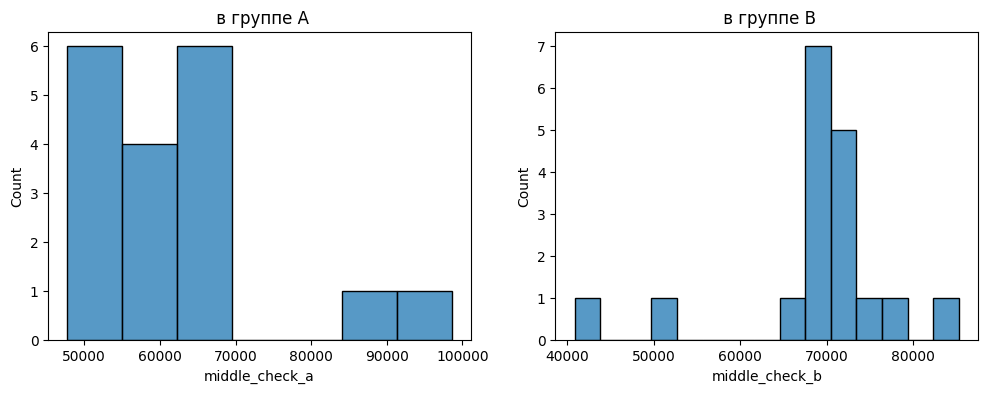

In [141]:
# Построим гистограммы средних чеков
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='middle_check_a', data=daily_a, ax=axes[0])
sns.histplot(x='middle_check_b', data=daily_b, ax=axes[1])
#задаём названия графикам
axes[0].set_title(' в группе А');
axes[1].set_title(' в группе B');

from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_a['middle_check_a'])
shapiro_result_b = shapiro(daily_b['middle_check_b'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

In [142]:
    
from scipy.stats import mannwhitneyu

H0 = 'Срение чеки А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.1 # уровень значимости

stat, p_value = mannwhitneyu(daily_a['middle_check_a'], daily_b['middle_check_b'], alternative='less')
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. Срение чеки А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B
